In [1]:
import pathlib

import requests
from pathlib import Path, PosixPath
import os
import pandas as pd

In [2]:
print(f"Note: data written to {os.getcwd()}/data")

Note: data written to /home/kh701/pycharm/mm-lego/notebooks/data


### Download from Xena hub

In [3]:
download_urls = { 
    "brca":
        {
            "survival": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FBRCA_survival.txt", 
            "clinical": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FBRCA_clinicalMatrix",
            "cnv": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz",
            "rnaseq": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FHiSeqV2_PANCAN.gz",
            "mut": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/mc3_gene_level%2FBRCA_mc3_gene_level.txt.gz",
        }, 
    "blca":
        {
            "survival": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FBLCA_survival.txt", 
            "clinical": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BLCA.sampleMap%2FBLCA_clinicalMatrix",
            "cnv": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BLCA.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz",
            "rnaseq": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BLCA.sampleMap%2FHiSeqV2_PANCAN.gz",
            "mut": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/mc3_gene_level%2FBLCA_mc3_gene_level.txt.gz",
        }, 
    "kirp": 
        {
            "survival": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FKIRP_survival.txt", 
            "clinical": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.KIRP.sampleMap%2FKIRP_clinicalMatrix",
            "cnv": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.KIRP.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz",
            "rnaseq": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.KIRP.sampleMap%2FHiSeqV2_PANCAN.gz",
            "mut": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/mc3_gene_level%2FKIRP_mc3_gene_level.txt.gz",
        },
    "ucec": 
        {
            "survival": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FUCEC_survival.txt", 
            "clinical": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.UCEC.sampleMap%2FUCEC_clinicalMatrix",
            "cnv": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.UCEC.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz",
            "rnaseq": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.UCEC.sampleMap%2FGAV2.gz",
            "mut": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/mc3_gene_level%2FUCEC_mc3_gene_level.txt.gz",
        }
}

In [22]:
# download and write text file

survival_dir = Path("/auto/archive/tcga/tcga/xena/raw/")
clinical_dir = Path("/auto/archive/tcga/tcga/xena/raw/")
def download(url: str, save_path: Path, rewrite: bool = False) -> None:
    print(f"Downloading to {save_path}")
    
    response = requests.get(url, stream=True)
    assert type(save_path) == PosixPath, f"save_path must be a Path object but got {type(save_path)}"
    print(response)
    
    if not os.path.exists(save_path.parent): 
        os.makedirs(save_path.parent, exist_ok=True)
    
    if os.path.exists(save_path) and not rewrite:
        print(f"File {save_path} already exists. Skipping download.")
        return None
    else:
        with open(save_path, 'wb') as fd:
            for chunk in response.iter_content(chunk_size=1024):
                fd.write(chunk)

# decompress .gz file
def decompress_gz(file_path: Path) -> None:
    assert file_path.suffix == ".gz", f"File must be a .gz file but got {file_path.suffix}"
    os.system(f"gunzip -f {file_path}")

# download all specified
def download_all(download_urls: dict, rewrite: bool = True) -> None: 
    """
    Download all files specified in the download_urls dictionary.
    Rewrites files by default
    Args:
        download_urls: dictionary containing download urls
    Returns:
        None, but writes xena hub files to `tcga/tcga/xena/raw`
    """
    for site in download_urls.keys():
        for data_type, url in download_urls[site].items():
            if url is not None: 
                write_path = f"/auto/archive/tcga/tcga/xena/raw/{site}_{data_type}.txt"
                if url.endswith(".gz"):
                    write_path = Path(str(write_path) + ".gz")
                else: 
                    write_path = Path(write_path)
                download(url=url, save_path=write_path, rewrite=rewrite)
                if write_path.suffix == ".gz":
                    decompress_gz(write_path)
  
# download_all(download_urls)


#### SurvPath preprocessing steps
1. drop duplicate case IDs
2. check if clinical data is available


BRCA: n=869

https://github.com/mahmoodlab/SurvPath/blob/fe4a97bf8fc57925dc81ff930ef7e1d9b2bbc83a/datasets/dataset_survival.py#L485

In [14]:
# general survival reference
gs = pd.read_csv("/auto/archive/tcga/tcga/omic/tcga_brca_all_clean.csv.zip", compression="zip")

print(f"Dropping duplicates: {gs['case_id'].duplicated().sum()}")

gs = gs.drop_duplicates(subset="case_id", keep="first")

Dropping duplicates: 66


In [15]:
gs.head()

,Unnamed: 0,case_id,slide_id,age,site,survival_months,censorship,is_female,oncotree_code,train,...,PIK3CA_mut,PTEN_mut,RYR2_mut,SPTA1_mut,SYNE1_mut,TP53_mut,TTN_mut,USH2A_mut,ZFHX4_mut,RAS_mut
0,0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,50.0,3C,131.57,1.0,1.0,IDC,1.0,...,0,0,1,1,0,1,1,0,1,0
2,2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,62.0,3C,48.42,1.0,1.0,IDC,1.0,...,0,0,0,0,0,0,1,0,1,0
4,4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,52.0,3C,47.57,1.0,1.0,IDC,1.0,...,1,0,0,0,0,0,0,0,0,0
5,5,TCGA-4H-AAAK,TCGA-4H-AAAK-01Z-00-DX1.ABF1B042-1970-4E28-867...,50.0,4H,11.43,1.0,1.0,ILC,1.0,...,0,0,0,0,0,0,0,0,0,0
6,6,TCGA-5L-AAT0,TCGA-5L-AAT0-01Z-00-DX1.5E171263-30BF-4C6B-88A...,42.0,5L,48.52,1.0,1.0,ILC,1.0,...,1,0,0,0,0,0,1,0,0,0


In [20]:
def write_csv(df: pd.DataFrame, write_path: str) -> None: 
    if write_path is None: 
        return None
    write_path = Path(write_path)
    # create path
    if not os.path.exists(write_path.parent): 
        os.makedirs(write_path.parent, exist_ok=True)
    df.to_csv(write_path)
    return None


def load_survival(site: str, write_path: str = None) -> pd.DataFrame:
    print(f"Loading {site.upper()} survival data...")
    survival = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_survival.txt", sep="\t")
    
    # filter slide overlap
    case_length = 12 # first 12 digits of WSI filename indicate the case number
    dir_name = f"/auto/archive/tcga/tcga/wsi/{site}/"
    slides = pd.DataFrame({"slide_id": [slide for slide in os.listdir(dir_name) if slide.endswith(".svs")]})
    slides.sort_values("slide_id", inplace=True)
    slides["_PATIENT"] = slides["slide_id"].str[:case_length]
    slides.set_index("_PATIENT", inplace=True)
    # remove duplicates
    slides = slides[~slides.index.duplicated(keep='first')]
    
    print(f"Dropping survival cases w/o slides: {survival[~survival['_PATIENT'].isin(slides.index)].shape[0]}")
    survival = survival[survival["_PATIENT"].isin(slides.index)]
    
    # merge with slide id
    survival = survival.merge(slides, left_on="_PATIENT", right_index=True, how="left")
    assert survival["slide_id"].isna().sum() == 0, "Some patients do not have slides"
    
    survival = survival.drop_duplicates(subset="_PATIENT", keep="first")
    
    survival.set_index("_PATIENT", inplace=True)
    
    # drop DSS nans
    survival = survival[~survival["DSS"].isna()]
    survival["DSS"] = survival["DSS"].astype(int)
    print(f"Survival shape: {survival.shape}")

    write_csv(survival, write_path)

    return survival

def load_clinical(site: str, write_path: str = None) -> pd.DataFrame:
    print(f"Loading {site.upper()} clinical data...")
    clinical = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_clinical.txt", sep="\t")
    
    # filter slide overlap
    case_length = 12 # first 12 digits of WSI filename indicate the case number
    dir_name = f"/auto/archive/tcga/tcga/wsi/{site}/"
    slides = pd.DataFrame({"slide_id": [slide for slide in os.listdir(dir_name) if slide.endswith(".svs")]})
    slides["_PATIENT"] = slides["slide_id"].str[:case_length]
    slides.set_index("_PATIENT", inplace=True)
    # remove duplicates
    slides = slides[~slides.index.duplicated(keep='first')]
    
    
    print(f"Dropping clinical cases w/o slides: {clinical[~clinical['_PATIENT'].isin(slides.index)].shape[0]}")
    clinical = clinical[clinical["_PATIENT"].isin(slides.index)]
    print(f"Dropping duplicates: {clinical['_PATIENT'].duplicated().sum()} from clinical data")
    
    
    
    clinical = clinical.drop_duplicates(subset="_PATIENT", keep="first")
    
    clinical["is_female"] = (clinical["gender"] == "FEMALE").astype("int")
    
    clinical.set_index("_PATIENT", inplace=True)
    
    print(f"Clinincal shape: {clinical.shape}")
    
    write_csv(clinical, write_path)
    
    return clinical


SITE = "brca"

survival = load_survival(SITE)
clinical = load_clinical(SITE)


Loading BRCA survival data...
Dropping survival cases w/o slides: 154
Survival shape: (937, 11)
Loading BRCA clinical data...
Dropping clinical cases w/o slides: 161
Dropping duplicates: 131 from clinical data
Clinincal shape: (955, 194)


In [23]:
site = "brca"
clinical = pd.read_csv(clinical_dir.joinpath(f"{site}_clinical.txt"), sep="\t")

# filter slide overlap
case_length = 12 # first 12 digits of WSI filename indicate the case number
dir_name = f"/auto/archive/tcga/tcga/wsi/{site}/"
slide_patients = pd.Series([slide[:case_length] for slide in os.listdir(dir_name) if slide.endswith(".svs")])
clinical.set_index("_PATIENT", inplace=True)
clinical.sort_index(inplace=True)

clinical.loc[:, clinical.columns.str.contains("age")]

,AJCC_Stage_nature2012,Converted_Stage_nature2012,age_at_initial_pathologic_diagnosis,axillary_lymph_node_stage_method_type,axillary_lymph_node_stage_other_method_descriptive_text,er_level_cell_percentage_category,pathologic_stage
_PATIENT,,,,,,,
TCGA-3C-AAAU,NaN,NaN,55.0,Sentinel lymph node biopsy plus axillary disse...,NaN,50-59%,Stage X
TCGA-3C-AALI,NaN,NaN,50.0,Sentinel lymph node biopsy plus axillary disse...,NaN,<10%,Stage IIB
TCGA-3C-AALJ,NaN,NaN,62.0,NaN,NaN,90-99%,Stage IIB
TCGA-3C-AALK,NaN,NaN,52.0,Sentinel node biopsy alone,NaN,70-79%,Stage IA
TCGA-4H-AAAK,NaN,NaN,50.0,Axillary lymph node dissection alone,NaN,60-69%,Stage IIIA
...,...,...,...,...,...,...,...
TCGA-XX-A899,NaN,NaN,46.0,Sentinel lymph node biopsy plus axillary disse...,NaN,90-99%,Stage IIIA
TCGA-XX-A899,NaN,NaN,46.0,Sentinel lymph node biopsy plus axillary disse...,NaN,90-99%,Stage IIIA
TCGA-XX-A89A,NaN,NaN,68.0,NaN,NaN,70-79%,Stage IIB


In [24]:
survival[survival["OS.time"] != survival["DFI.time"]]

,sample,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,slide_id
_PATIENT,,,,,,,,,,,
TCGA-3C-AALK,TCGA-3C-AALK-01,0,1448.0,0,1448.0,NaN,NaN,0,1448.0,NaN,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...
TCGA-5L-AAT0,TCGA-5L-AAT0-01,0,1477.0,0,1477.0,NaN,NaN,0,1477.0,NaN,TCGA-5L-AAT0-01Z-00-DX1.5E171263-30BF-4C6B-88A...
TCGA-5L-AAT1,TCGA-5L-AAT1-01,0,1471.0,0,1471.0,NaN,NaN,0,1471.0,NaN,TCGA-5L-AAT1-01Z-00-DX1.F3449A5B-2AC4-4ED7-BF4...
TCGA-5T-A9QA,TCGA-5T-A9QA-01,0,303.0,0,303.0,NaN,NaN,0,303.0,NaN,TCGA-5T-A9QA-01Z-00-DX1.B4212117-E0A7-4EF2-B32...
TCGA-A1-A0SK,TCGA-A1-A0SK-01,1,967.0,1,967.0,NaN,NaN,1,967.0,NaN,TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD...
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-PL-A8LY,TCGA-PL-A8LY-01,0,8.0,0,8.0,NaN,NaN,0,8.0,NaN,TCGA-PL-A8LY-01A-01-DX1.32047D5E-8A42-480A-B2B...
TCGA-PL-A8LZ,TCGA-PL-A8LZ-01,0,302.0,0,302.0,NaN,NaN,0,302.0,NaN,TCGA-PL-A8LZ-01A-01-DX1.B9F233EE-06DD-4C14-A39...
TCGA-UL-AAZ6,TCGA-UL-AAZ6-01,0,518.0,0,518.0,NaN,NaN,0,518.0,NaN,TCGA-UL-AAZ6-01Z-00-DX1.0488628B-C06B-4A1D-919...


In [25]:
clinical.head()

,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
_PATIENT,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,NaN,TCGA-3C-AAAU-01A-11D-A41E-01,TCGA-3C-AAAU-01,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,TCGA-3C-AAAU-01A-11D-A41E-01,NaN
TCGA-3C-AALI,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NaN,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NaN
TCGA-3C-AALJ,TCGA-3C-AALJ-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,NaN,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NaN
TCGA-3C-AALK,TCGA-3C-AALK-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1a19e068-d213-41ef-aebb-104017a883cc,NaN,TCGA-3C-AALK-01A-11D-A41E-01,TCGA-3C-AALK-01,NaN,1a19e068-d213-41ef-aebb-104017a883cc,TCGA-3C-AALK-01A-11D-A41E-01,NaN
TCGA-4H-AAAK,TCGA-4H-AAAK-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,NaN,TCGA-4H-AAAK-01A-12D-A41E-01,TCGA-4H-AAAK-01,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,TCGA-4H-AAAK-01A-12D-A41E-01,NaN


In [30]:
sp_clinical = pd.read_csv("../SurvPath/datasets_csv/clinical_data/tcga_brca_clinical.csv")
sp_survival = pd.read_csv("../SurvPath/datasets_csv/metadata/tcga_brca.csv")
print("RAW")
print(f"survival: {sp_survival.shape}, clinical: {sp_clinical.shape}")
print(f"Dropping duplicates: {sp_survival['case_id'].duplicated().sum()} from survival data")
print(f"Dropping duplicates: {sp_clinical['case_id'].duplicated().sum()} from clinical data")
sp_survival = sp_survival.drop_duplicates(subset="case_id", keep="first")
sp_clinical = sp_clinical.drop_duplicates(subset="case_id", keep="first")
print("FILTERED")
print(f"survival: {sp_survival.shape}, clinical: {sp_clinical.shape}")

RAW
survival: (931, 14), clinical: (1108, 5)
Dropping duplicates: 60 from survival data
Dropping duplicates: 7 from clinical data
FILTERED
survival: (871, 14), clinical: (1101, 5)


In [12]:
# sp_survival
case_length = 12 # first 12 digits of WSI filename indicate the case number
dir_name = "/auto/archive/tcga/tcga/wsi/brca/"

slide_patients = pd.Series([slide[:case_length] for slide in os.listdir(dir_name) if slide.endswith(".svs")])

survival.index.isin(slide_patients).sum()

# df[df["_PATIENT"].isin(slide_patients)]
# for slide in os.listdir(dir_name): 
#     case_id = slide[:case_length]
    # if case_id not in sp_survival["case_id"].values: 
    #     print(f"Case ID {case_id} not in survival data")
# df["_PATIENT"].str.len().unique()

937

In [31]:
master = survival.merge(clinical, left_index=True, right_index=True, how="left")

master[~master.index.isin(sp_survival["case_id"])]

,sample,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
_PATIENT,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,TCGA-A1-A0SB-01,0,259.0,0,259.0,0.0,259.0,0,259.0,NaN,...,TCGA-A1-A0SB-01A-11D-A142-09,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,NaN,TCGA-A1-A0SB-01A-11D-A141-01,TCGA-A1-A0SB-01,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,TCGA-A1-A0SB-01A-11D-A141-01,NaN
TCGA-A1-A0SE,TCGA-A1-A0SE-01,0,1321.0,0,1321.0,0.0,1321.0,0,1321.0,NaN,...,TCGA-A1-A0SE-01A-11D-A099-09,TCGA-A1-A0SE-01,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01,TCGA-A1-A0SE-01A-11D-A087-01,NaN,TCGA-A1-A0SE-01A-11R-A084-07,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01A-11D-A087-01,TCGA-A1-A0SE-01
TCGA-A1-A0SK,TCGA-A1-A0SK-01,1,967.0,1,967.0,NaN,NaN,1,967.0,NaN,...,TCGA-A1-A0SK-01A-12D-A099-09,TCGA-A1-A0SK-01,a63583ca-0ef2-4417-b435-5f3a6951d0c2,TCGA-A1-A0SK-01,TCGA-A1-A0SK-01A-12D-A087-01,NaN,TCGA-A1-A0SK-01A-12R-A084-07,a63583ca-0ef2-4417-b435-5f3a6951d0c2,TCGA-A1-A0SK-01A-12D-A087-01,TCGA-A1-A0SK-01
TCGA-A2-A0YI,TCGA-A2-A0YI-01,0,1505.0,0,1505.0,0.0,1505.0,0,1505.0,NaN,...,TCGA-A2-A0YI-01A-31D-A10M-09,TCGA-A2-A0YI-01,4de3ad78-68e4-4ab9-b1f6-eb0666140761,TCGA-A2-A0YI-01,TCGA-A2-A0YI-01A-31D-A10L-01,NaN,TCGA-A2-A0YI-01A-31R-A10J-07,4de3ad78-68e4-4ab9-b1f6-eb0666140761,TCGA-A2-A0YI-01A-31D-A10L-01,TCGA-A2-A0YI-01
TCGA-A2-A3KD,TCGA-A2-A3KD-01,0,1206.0,0,1206.0,NaN,NaN,0,1206.0,NaN,...,NaN,NaN,8a224dc6-632b-418b-bd5e-bcefc8ad049e,NaN,TCGA-A2-A3KD-01A-12D-A20R-01,TCGA-A2-A3KD-01,NaN,8a224dc6-632b-418b-bd5e-bcefc8ad049e,TCGA-A2-A3KD-01A-12D-A20R-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A5RX,TCGA-OL-A5RX-01,0,878.0,0,878.0,0.0,878.0,0,878.0,NaN,...,NaN,NaN,650c0c98-4432-4e9a-9e83-4ad8a7a0d628,NaN,TCGA-OL-A5RX-01A-11D-A28A-01,TCGA-OL-A5RX-01,NaN,650c0c98-4432-4e9a-9e83-4ad8a7a0d628,TCGA-OL-A5RX-01A-11D-A28A-01,NaN
TCGA-OL-A5RY,TCGA-OL-A5RY-01,0,752.0,0,752.0,0.0,752.0,0,752.0,NaN,...,NaN,NaN,2407816a-86e7-4094-a028-e81c0cda5448,NaN,TCGA-OL-A5RY-01A-21D-A28A-01,TCGA-OL-A5RY-01,NaN,2407816a-86e7-4094-a028-e81c0cda5448,TCGA-OL-A5RY-01A-21D-A28A-01,NaN
TCGA-OL-A5RZ,TCGA-OL-A5RZ-01,0,679.0,0,679.0,0.0,679.0,0,679.0,NaN,...,NaN,NaN,fc8c0c74-cd1b-4bc7-ab1d-568d302c5719,NaN,TCGA-OL-A5RZ-01A-11D-A28A-01,TCGA-OL-A5RZ-01,NaN,fc8c0c74-cd1b-4bc7-ab1d-568d302c5719,TCGA-OL-A5RZ-01A-11D-A28A-01,NaN


In [32]:
# check_col
col = "mtsttc_brst_crcnm_mmnhstchmstry_prgstrn_rcptr_pstv_fndng_scl_typ"

# cancidates: "icd_10"

print(master[~master.index.isin(sp_survival["case_id"])][col].unique())
print(master[master.index.isin(sp_survival["case_id"])][col].unique())

[nan]
[nan '3 Point Scale' '4 Point Scale' 'Other Reporting Scale']


In [33]:
master[master.index.isin(sp_survival["case_id"])]

,sample,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
_PATIENT,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AALI,TCGA-3C-AALI-01,0,4005.0,0,4005.0,0.0,4005.0,0,4005.0,NaN,...,NaN,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NaN,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NaN
TCGA-3C-AALJ,TCGA-3C-AALJ-01,0,1474.0,0,1474.0,0.0,1474.0,0,1474.0,NaN,...,NaN,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,NaN,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NaN
TCGA-3C-AALK,TCGA-3C-AALK-01,0,1448.0,0,1448.0,NaN,NaN,0,1448.0,NaN,...,NaN,NaN,1a19e068-d213-41ef-aebb-104017a883cc,NaN,TCGA-3C-AALK-01A-11D-A41E-01,TCGA-3C-AALK-01,NaN,1a19e068-d213-41ef-aebb-104017a883cc,TCGA-3C-AALK-01A-11D-A41E-01,NaN
TCGA-4H-AAAK,TCGA-4H-AAAK-01,0,348.0,0,348.0,0.0,348.0,0,348.0,NaN,...,NaN,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,NaN,TCGA-4H-AAAK-01A-12D-A41E-01,TCGA-4H-AAAK-01,NaN,2ea9e472-a408-4ae0-975d-50a566f22b2a,TCGA-4H-AAAK-01A-12D-A41E-01,NaN
TCGA-5L-AAT0,TCGA-5L-AAT0-01,0,1477.0,0,1477.0,NaN,NaN,0,1477.0,NaN,...,NaN,NaN,32e61645-eb89-49f7-9876-85b1497c7e42,NaN,TCGA-5L-AAT0-01A-12D-A41E-01,TCGA-5L-AAT0-01,NaN,32e61645-eb89-49f7-9876-85b1497c7e42,TCGA-5L-AAT0-01A-12D-A41E-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XX-A899,TCGA-XX-A899-01,0,467.0,0,467.0,0.0,467.0,0,467.0,NaN,...,NaN,NaN,8e339298-3e3c-4b31-96a9-a842e973e583,NaN,TCGA-XX-A899-01A-11D-A36I-01,TCGA-XX-A899-01,NaN,8e339298-3e3c-4b31-96a9-a842e973e583,TCGA-XX-A899-01A-11D-A36I-01,NaN
TCGA-XX-A899,TCGA-XX-A899-01,0,467.0,0,467.0,0.0,467.0,0,467.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-XX-A89A,TCGA-XX-A89A-01,0,488.0,0,488.0,0.0,488.0,0,488.0,NaN,...,NaN,NaN,501a70d8-3932-49c0-aa13-774756fb89e3,NaN,TCGA-XX-A89A-01A-11D-A36I-01,TCGA-XX-A89A-01,NaN,501a70d8-3932-49c0-aa13-774756fb89e3,TCGA-XX-A89A-01A-11D-A36I-01,NaN


In [34]:
sp_clinical = pd.read_csv("../SurvPath/datasets_csv/clinical_data/tcga_brca_clinical.csv")
sp_survival = pd.read_csv("../SurvPath/datasets_csv/metadata/tcga_brca.csv")
print(f"survival: {sp_survival.shape}, clinical: {sp_clinical.shape}")

survival: (931, 14), clinical: (1108, 5)


In [35]:
# check survival data
sp_survival.drop_duplicates(subset="case_id", keep="first")

,Unnamed: 0,case_id,slide_id,age,site,survival_months,survival_months_dss,survival_months_pfi,censorship,censorship_dss,censorship_pfi,is_female,oncotree_code,train
0,0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,50.0,3C,133.500000,133.500000,133.500000,1,1,1,1.0,IDC,1.0
2,2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,62.0,3C,49.133333,49.133333,49.133333,1,1,1,1.0,IDC,1.0
4,4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,52.0,3C,48.266667,48.266667,48.266667,1,1,1,1.0,IDC,1.0
5,5,TCGA-4H-AAAK,TCGA-4H-AAAK-01Z-00-DX1.ABF1B042-1970-4E28-867...,50.0,4H,11.600000,11.600000,11.600000,1,1,1,1.0,ILC,1.0
6,6,TCGA-5L-AAT0,TCGA-5L-AAT0-01Z-00-DX1.5E171263-30BF-4C6B-88A...,42.0,5L,49.233333,49.233333,49.233333,1,1,1,1.0,ILC,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,926,TCGA-WT-AB44,TCGA-WT-AB44-01Z-00-DX1.B6ECEA7C-DA26-4B34-88C...,77.0,WT,29.433333,29.433333,29.433333,1,1,1,1.0,ILC,1.0
927,927,TCGA-XX-A899,TCGA-XX-A899-01Z-00-DX1.08FE27B7-73B8-4CE3-ACF...,46.0,XX,15.566667,15.566667,15.566667,1,1,1,1.0,ILC,1.0
928,928,TCGA-XX-A89A,TCGA-XX-A89A-01Z-00-DX1.671E2AD6-4D1A-4579-88C...,68.0,XX,16.266667,16.266667,16.266667,1,1,1,1.0,ILC,1.0
929,929,TCGA-Z7-A8R5,TCGA-Z7-A8R5-01Z-00-DX1.3BDB407F-514C-4131-B05...,61.0,Z7,109.566667,109.566667,6.033333,1,1,0,1.0,ILC,1.0


In [36]:
#get overlap of _PATIENT between df and dfc
clinical.index.isin(survival.index).sum()

1057

## Recreate curated omic data
- Mixture of clinical and omic variables

### Copy number variation

We are taking the thresholded gistic2 copy numbers from the Xena data hub. 

Description: 
TCGA breast invasive carcinoma (BRCA) thresholded gene-level copy number variation (CNV) estimated using the GISTIC2 method. Copy number profile was measured experimentally using whole genome microarray at a TCGA genome characterization center. Subsequently, GISTIC2 method was applied using the TCGA FIREHOSE pipeline to produce gene-level copy number estimates. GISTIC2 further thresholded the estimated values to -2,-1,0,1,2, representing homozygous deletion, single copy deletion, diploid normal copy, low-level copy number amplification, or high-level copy number amplification. Genes are mapped onto the human genome coordinates using UCSC xena HUGO probeMap. Reference to GISTIC2 method PMID:21527027.

Gisctic2.0 thresholded CNV meanings: 
* -2: Homozygous deletion. Both copies of the gene are deleted, which can lead to the loss of tumor suppressor gene function.
* -1: Single copy deletion. One copy of the gene is deleted, which might reduce the gene's function and could be significant if it's a tumor suppressor gene.
* 0: Neutral / No change. The gene has the expected number of copies, suggesting it might not be involved in the cancer process for this patient.
* 1: Low-level amplification. There is a slight increase in the number of copies of the gene, which could enhance the gene's function, potentially significant if the gene is an oncogene.
* 2: High-level amplification. There is a significant increase in the number of copies of the gene, strongly suggesting the gene's enhanced function could be driving the cancer process.

#### Download

In [21]:
download_dict = {
    "cnv": "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.BRCA.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz", 
    "rnaseq": None,
}
# 
# write_path = Path("data/tcga/omic/xena/cnv/brca_cnv.txt")
# if download_dict["cnv"].endswith(".gz"):
#     write_path = Path(str(write_path) + ".gz")
# 
# # download cnv data
# download(save_path=write_path, url=download_dict["cnv"])
# 
# if write_path.suffix == ".gz":
#     decompress_gz(write_path)

# Copy numbers variations
# cnv = pd.read_csv("data/tcga/omic/xena/cnv/brca_cnv.txt", sep="")

#### Load and preprocess from txt file

In [45]:
def load_cnv_ref(site: str, write_path: str = None): 
    """
    Load same CNV features as in the reference
    Returns:
    """
    cnv = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_cnv.txt", sep="\t")
    ref = pd.read_csv(f"/auto/archive/tcga/tcga/omic/tcga_{site}_all_clean.csv.zip", index_col="case_id", compression='zip')
    # filter ref cnv columns
    ref = ref.loc[:, ref.columns.str.endswith("_cnv")]
    
    cnv = cnv.T
    cnv.head()
    cnv.columns = cnv.iloc[0]
    cnv = cnv[1:] # drop first header
    # get case id as index (only first 12 digits)
    cnv.index = cnv.index.str[:12]
    # drop duplicates
    cnv = cnv[~cnv.index.duplicated(keep='first')]
    # set first row as header
    # sort alphabetically
    cnv = cnv.sort_index(axis=1)
    
    # match column names
    cnv.columns = [col.upper() + "_cnv" for col in cnv.columns]
    
    mask = cnv.columns.isin(ref.columns)
    # mask coverage
    print(f"Coverage: {mask.sum()}/{ref.shape[1]}")
    
    cnv_filtered = cnv.loc[:, mask]
    write_csv(cnv_filtered, write_path)
    # write
    return cnv_filtered, None, cnv
    
cnv_filtered, _, cnv_all = load_cnv_ref("brca")

Coverage: 1333/1333


In [47]:
def load_cnv(site: str, write_path: str = None): 
    print(f"Loading {site.upper()} CNV data...")
    cnv = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_cnv.txt", sep="\t")
    # some basic reformatting
    
    cnv = cnv.T
    cnv.head()
    cnv.columns = cnv.iloc[0]
    cnv = cnv[1:] # drop first header
    # get case id as index (only first 12 digits)
    cnv.index = cnv.index.str[:12]
    # drop duplicates
    cnv = cnv[~cnv.index.duplicated(keep='first')]
    # set first row as header
    # sort alphabetically
    cnv = cnv.sort_index(axis=1)
    # filter out columns containing "|"
    # cnv = cnv.loc[:, ~cnv.columns.str.contains("\|")]
    
    # drop columns with all nans (if any)
    cnv = cnv.dropna(axis=1, how="all")
    cnv = cnv.dropna(axis=0, how="all")
    # # drop columns with only single value
    cnv = cnv.loc[:, cnv.nunique() > 1]
    cnv_all = cnv.copy()
    
    # In line with other papers, we filter out the genes with a CNV=2 (high-level amplification) ratio of greater than 10%.
    cnv_dist = cnv.apply(lambda x: x.value_counts()/x.shape)
    copy_threshold = 0.098 # threshold for highest copy number values
    cnv_mask = cnv_dist.iloc[-1] >= copy_threshold
    print(f"Removing {len(cnv_mask) - cnv_mask.sum()} genes with CNV=2 ratio greater than {copy_threshold}")
    
    # alternative cnv mask - it would also make sense to filter out genes with CNV=-2 (homozygous deletion) ratio of greater than 10%.
    # cnv_mask = cnv_dist.iloc[-1] > 0.15 | cnv_dist.iloc[0] > 0.01
    
    cnv_filtered = cnv[cnv_mask.index[cnv_mask]]
    cnv_filtered.columns = [f"{col}_cnv" for col in cnv_filtered.columns]
    
    cnv_filtered, duplicate_cols = remove_duplicate_cols(cnv_filtered)
    
    write_csv(cnv_filtered, write_path)
    print(f"CNV shape: {cnv_filtered.shape}")
    
    return cnv_filtered, duplicate_cols, cnv_all
    
    
def remove_duplicate_cols(df):
    """
    Removes duplicated columns from a DataFrame, keeping the first occurrence.

    Parameters:
    df (pd.DataFrame): The input DataFrame from which duplicate columns are to be removed.

    Returns:
    pd.DataFrame: A new DataFrame with duplicate columns removed.
    """
    # Initialize a list to hold the hashes of each column
    column_hashes = []

    # Initialize a list to hold the names of unique columns
    unique_columns = []
    duplicate_cols = []

    for col in df.columns:
        # Convert the column to a hashable type (tuple) and hash it
        col_hash = hash(tuple(df[col]))

        # If the hash is not already in the list, it's a unique column
        if col_hash not in column_hashes:
            column_hashes.append(col_hash)
            unique_columns.append(col)
        else: 
            duplicate_cols.append(col)
    
    print(f"Removed {len(duplicate_cols)} duplicate columns")
    # Use the unique columns to create a new DataFrame without duplicates
    return df[unique_columns], duplicate_cols

# old call
cnv, duplicate_cols, cnv_all = load_cnv(site="brca")
    


Loading BRCA CNV data...
Removing 23103 genes with CNV=2 ratio greater than 0.098
Removed 535 duplicate columns
CNV shape: (1080, 1138)


#### Quick data consistency check

In [48]:
# check consistency with reference
import numpy as np

ref_df = pd.read_csv("/auto/archive/tcga/tcga/omic/tcga_brca_all_clean.csv.zip", index_col="case_id", compression='zip')
ref_df = ref_df[~ref_df.index.duplicated(keep='first')]
ref_df = ref_df.loc[:, ref_df.columns.str.contains("_cnv")]

for col in ref_df.columns: 
    try: 
        merged = pd.merge(ref_df[col], cnv[col], left_index=True, right_index=True, suffixes=["_ref", ""], how="left")
    except KeyError:
        if col in duplicate_cols:
            print(f"Column {col} was filtered out as a duplicate")
        else: 
            print(f"Column {col} not in cnv")
        continue
        
    np.testing.assert_array_equal(merged[col], merged[f"{col}_ref"])


Column ANKRD20A12P_cnv was filtered out as a duplicate
Column ANKRD34A_cnv was filtered out as a duplicate
Column ANKRD35_cnv was filtered out as a duplicate
Column BCL9_cnv was filtered out as a duplicate
Column BOLA1_cnv was filtered out as a duplicate
Column CD160_cnv was filtered out as a duplicate
Column CHD1L_cnv was filtered out as a duplicate
Column FAM72B_cnv was filtered out as a duplicate
Column FAM72C_cnv was filtered out as a duplicate
Column FAM72D_cnv was filtered out as a duplicate
Column FCGR1A_cnv was filtered out as a duplicate
Column FCGR1B_cnv was filtered out as a duplicate
Column FMO5_cnv was filtered out as a duplicate
Column GJA5_cnv was filtered out as a duplicate
Column GJA8_cnv was filtered out as a duplicate
Column GNRHR2_cnv was filtered out as a duplicate
Column GPR89A_cnv was filtered out as a duplicate
Column GPR89B_cnv was filtered out as a duplicate
Column HIST2H2AA3_cnv was filtered out as a duplicate
Column HIST2H2AA4_cnv was filtered out as a dupli

### Mutation

Mutation data for all genes. Encoded as 0 (no mutation) or 1 (mutation). 

Note that there might be slight differences to the reference in terms of which genes are filtered since we are not pre-filtering cases for which we don't have slides (i.e., the patient samples off which the ratios are calculated are slightly different).  

In [24]:
download_path = "https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/mc3_gene_level%2FBRCA_mc3_gene_level.txt.gz"
write_path = Path("data/tcga/omic/xena/mut/brca_mut.txt")

if download_path.endswith(".gz"):
    write_path = Path(str(write_path) + ".gz")

# download cnv data
download(save_path=write_path, url=download_path, rewrite=True)

if write_path.suffix == ".gz":
    decompress_gz(write_path)

<Response [200]>


In [58]:
def load_mutations_ref(site: str, write_path: str = None): 
    """
    Load same CNV features as in the reference
    Returns:
    """
    mut = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_mut.txt", sep="\t")
    ref = pd.read_csv(f"/auto/archive/tcga/tcga/omic/tcga_{site}_all_clean.csv.zip", index_col="case_id", compression='zip')
    # filter ref cnv columns
    ref = ref.loc[:, ref.columns.str.endswith("_mut")]
    
    mut = mut.T
    mut.columns = mut.iloc[0]
    mut = mut[1:] # drop first header
    # get case id as index (only first 12 digits)
    mut.index = mut.index.str[:12]
    
    mut.columns = [str(col).upper() + "_mut" for col in mut.columns]
    # mut.head()
    mask = mut.columns.isin(ref.columns)
    # mask coverage
    print(f"Coverage: {mask.sum()}/{ref.shape[1]}")
    
    mut_filtered = mut.loc[:, mask]
    write_csv(mut_filtered, write_path)
    
    return mut_filtered, None, mut

mut_filtered, _, mut = load_mutations_ref("brca")

Coverage: 20/21


In [59]:
def load_mutations(site: str, write_path: str = None): 
    print(f"Loading {site.upper()} mutation data...")
    mut = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_mut.txt", sep="\t")
    mut = mut.T
    mut.columns = mut.iloc[0]
    mut = mut[1:] # drop first header
    mut.index = mut.index.str[:12]
    
    print(f"Raw shape: {mut.shape}")
    
    # filter columns summing to 0
    mask = mut.sum() > 0
    print(f"Removing {mask.sum()} genes with no mutations")
    mut = mut.loc[:, mask]
    
    # filter out genes with fewer than 5% mutations
    mutation_thresholds = { 
        "brca": 0.03, 
        "blca": 0.03, 
        "kirp": 0.03, 
        "ucec": 0.1
    }
    mut_dist = mut.apply(lambda x: x.value_counts()/x.shape)
    mut_mask = mut_dist.iloc[-1] > mutation_thresholds[site]
    print(f"Removing {len(mut_mask) - mut_mask.sum()} genes with less than 3% mutations")
    mut = mut.loc[:, mut_mask]
    
    # sort columns
    mut = mut.sort_index(axis=1)
    mut_all = mut.copy()
    # remove duplicate cols (genes with the same mutation pattern across all patients)
    mut, duplicate_cols = remove_duplicate_cols(mut)
    
    mut.columns = [col + "_mut" for col in mut.columns]
    
    mut = mut.astype(int)
    print(f"Mutation shape: {mut.shape}")
    
    write_csv(mut, write_path)
    
    return mut, duplicate_cols, mut_all

mut, _, mut_all = load_mutations(site="brca")

Loading BRCA mutation data...
Raw shape: (791, 40543)
Removing 15514 genes with no mutations
Removing 15450 genes with less than 3% mutations
Removed 0 duplicate columns
Mutation shape: (791, 64)


#### Validation


#### TODO
Some patients have mismatching mutations, double check this. 
Not sure where this is coming from.

In [60]:
ref_df = pd.read_csv("/auto/archive/tcga/tcga/omic/tcga_brca_all_clean.csv.zip", index_col="case_id", compression='zip')
ref_df = ref_df[~ref_df.index.duplicated(keep='first')]
ref_df = ref_df.loc[:, ref_df.columns.str.contains("_mut")]

for col in ref_df.columns: 
    try: 
        merged = pd.merge(ref_df[col], mut[col], left_index=True, right_index=True, suffixes=["_ref", ""], how="inner").fillna(0).astype(int)
    except KeyError:
        if col in duplicate_cols:
            print(f"Column {col} was filtered out as a duplicate")
        else: 
            print(f"Column {col} not in mut")
        continue

    try: 
        np.testing.assert_array_equal(merged[col], merged[f"{col}_ref"])
    except AssertionError as e: 
        print(f"Error in column {col}")
        print(merged[merged[col] != merged[f"{col}_ref"]])

Error in column CDH1_mut
              CDH1_mut_ref  CDH1_mut
TCGA-A2-A0EN             1         0
TCGA-BH-A0BA             1         0
TCGA-BH-A0C0             1         0
TCGA-LL-A73Z             1         0
TCGA-OL-A5RV             1         0
Error in column DMD_mut
              DMD_mut_ref  DMD_mut
TCGA-BH-A0H9            1        0
TCGA-XX-A89A            1        0
Column DST_mut not in mut
Error in column FLG_mut
              FLG_mut_ref  FLG_mut
TCGA-A7-A0CH            1        0
TCGA-BH-A0DP            1        0
TCGA-BH-A0DZ            1        0
TCGA-D8-A27G            1        0
TCGA-D8-A27P            1        0
Error in column GATA3_mut
              GATA3_mut_ref  GATA3_mut
TCGA-AC-A8OR              1          0
TCGA-LD-A7W5              1          0
Error in column HMCN1_mut
              HMCN1_mut_ref  HMCN1_mut
TCGA-A2-A4S1              1          0
TCGA-BH-A0AY              1          0
TCGA-BH-A208              1          0
Error in column KMT2C_mut
             

### RNAseq

In [61]:
def load_rnaseq_ref(site:str, write_path: str = None): 
    """
    Load same CNV features as in the reference
    Returns:
    """
    rna = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_rnaseq.txt", sep="\t")
    ref = pd.read_csv(f"/auto/archive/tcga/tcga/omic/tcga_{site}_all_clean.csv.zip", index_col="case_id", compression='zip')
    # filter ref cnv columns
    ref = ref.loc[:, ref.columns.str.contains("_rnaseq")]
    
    rna = rna.T
    rna.columns = rna.iloc[0]
    rna = rna[1:] # drop first header
    # get case id as index (only first 12 digits)
    rna.index = rna.index.str[:12]
    
    rna.columns = [str(col).upper() + "_rnaseq" for col in rna.columns]
    # mut.head()
    mask = rna.columns.isin(ref.columns)
    # mask coverage
    print(f"Coverage: {mask.sum()}/{ref.shape[1]}")
    
    rna_filtered = rna.loc[:, mask]
    write_csv(rna_filtered, write_path)
    
    return rna_filtered, None, rna

rna_filtered, _, rna = load_rnaseq_ref("brca")

Coverage: 1523/1558


In [62]:
def load_rnaseq(site: str, write_path: str = None): 
    print(f"Loading {site.upper()} RNAseq data...")
    rna = pd.read_csv(f"/auto/archive/tcga/tcga/xena/raw/{site}_rnaseq.txt", sep="\t")
    rna = rna.T
    rna.columns = rna.iloc[0]
    rna = rna[1:] # drop first header
    print(f"Initial shape: {rna.shape}")
    rna.index = rna.index.str[:12]
    
    
    
    # drop duplicates
    duplicate_mask = rna.index.duplicated(keep='first')
    rna = rna[~duplicate_mask]
    print(f"Removed {duplicate_mask.sum()} duplicate rows")
    
    # drop duplicate genes (columns)
    rna, duplicate_cols = remove_duplicate_cols(rna)
    
    # sort index
    rna = rna.sort_index(axis=1)
    
    rna.columns = [col + "_rnaseq" for col in rna.columns]
    
    # load RNA families subset reference
    ref_df = pd.read_csv("/auto/archive/tcga/tcga/omic/tcga_brca_all_clean.csv.zip", index_col="case_id", compression='zip')
    ref_cols = ref_df.columns[ref_df.columns.str.contains("rnaseq")]
    # overlap
    ref_cols = ref_cols[ref_cols.isin(rna.columns)]
    print(f"Selecting {len(ref_cols)} gene expressions from reference")
    rna = rna.loc[:, ref_cols]
    
    write_csv(rna, write_path)

    print(f"RNA shape: {rna.shape}")
    
    return rna


rna = load_rnaseq(site="brca")

Loading BRCA RNAseq data...
Initial shape: (1218, 20530)
Removed 121 duplicate rows
Removed 211 duplicate columns
Selecting 1523 gene expressions from reference
RNA shape: (1097, 1523)


### Load master data for all sites

In [75]:
def load_master(
        site: str, 
        ref: bool = False,
) -> pd.DataFrame:
    """
    
    Args:
        site (str): tcga site 
        ref (bool): if true, usees reference data columns instead of own filtering

    Returns:
        pd.DataFrame: master data
    """
    clinical_vars = {"age_at_initial_pathologic_diagnosis": "age", 
                     "pathologic_stage": "stage",
                     "clinical_stage": "stage",
                     "tissue_source_site": "site",
                     "is_female": "is_female", 
                     "histological_type": "oncotree_code"
                     }
    
    base_path = Path("/auto/archive/tcga/tcga/")
    
    
    survival = load_survival(site, write_path = f"/auto/archive/tcga/tcga/xena/prep/{site}_survival.csv")
    clinical = load_clinical(site, write_path = f"/auto/archive/tcga/tcga/xena/prep/{site}_clinical.csv")
    clinical = clinical.rename(clinical_vars, axis=1, errors="ignore")
    clinical = clinical[list(clinical_vars.values())]
    
    if ref: 
        cnv, _, _ = load_cnv_ref(site, write_path = f"/auto/archive/tcga/tcga/xena/prep_ref/{site}_cnv.csv")
        mut, _, _ = load_mutations_ref(site, write_path=f"/auto/archive/tcga/tcga/xena/prep_ref/{site}_mut.csv")
        rna, _, _ = load_rnaseq_ref(site, write_path=f"/auto/archive/tcga/tcga/xena/prep_ref/{site}_rnaseq.csv")
    else: 
        cnv, _, _ = load_cnv(site, write_path = f"/auto/archive/tcga/tcga/xena/prep/{site}_cnv.csv")
        mut, _, _ = load_mutations(site, write_path=f"/auto/archive/tcga/tcga/xena/prep/{site}_mut.csv")
        rna = load_rnaseq(site, write_path=f"/auto/archive/tcga/tcga/xena/prep/{site}_rnaseq.csv")
    
    
    # write individual
    
    master = survival.merge(clinical, left_index=True, right_index=True, how="left")
    master = master.merge(cnv, left_index=True, right_index=True, how="left")
    master = master.merge(rna, left_index=True, right_index=True, how="left")
    master = master.merge(mut, left_index=True, right_index=True, how="left")
    # fill missing mutation data with 0 (assuming no mutation)
    master.loc[:, master.columns.str.endswith("_mut")] = master.loc[:, master.columns.str.endswith("_mut")].fillna(0)
    subdir = "ref" if ref else "custom"
    
    # name index as _PATIENT
    master.index.name = "_PATIENT"
    master.to_csv(f"/auto/archive/tcga/tcga/omic_xena/{subdir}/{site}_master.csv")
    
    return master


In [76]:
sites = ["blca", "brca", "kirp", "ucec"]
# sites = ["brca"]

for site in sites: 
    master = load_master(site, ref=True)
    print(f"{site} master shape: {master.shape}")


Loading BLCA survival data...
Dropping survival cases w/o slides: 43
Survival shape: (359, 11)
Loading BLCA clinical data...
Dropping clinical cases w/o slides: 43
Dropping duplicates: 21 from clinical data
Clinincal shape: (372, 130)
Coverage: 256/256
Coverage: 368/371
Coverage: 1519/1554
blca master shape: (376, 2160)
Loading BRCA survival data...
Dropping survival cases w/o slides: 154
Survival shape: (937, 11)
Loading BRCA clinical data...
Dropping clinical cases w/o slides: 161
Dropping duplicates: 131 from clinical data
Clinincal shape: (955, 194)
Coverage: 1333/1333
Coverage: 20/21
Coverage: 1523/1558
brca master shape: (1035, 2893)
Loading KIRP survival data...
Dropping survival cases w/o slides: 21
Survival shape: (272, 11)
Loading KIRP clinical data...
Dropping clinical cases w/o slides: 21
Dropping duplicates: 55 from clinical data
Clinincal shape: (276, 109)
Coverage: 0/0
Coverage: 19/20
Coverage: 1522/1557
kirp master shape: (300, 1560)
Loading UCEC survival data...
Droppi

In [77]:
### Inspect master
import pandas as pd
master = pd.read_csv("/auto/archive/tcga/tcga/omic_xena/ref/brca_master.csv", index_col="_PATIENT", low_memory=False)

In [78]:
master.head()

,sample,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,...,KMT2C_mut,NCOR1_mut,CDH1_mut,RYR2_mut,FLG_mut,PTEN_mut,PIK3CA_mut,HMCN1_mut,GATA3_mut,TTN_mut
_PATIENT,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AALI,TCGA-3C-AALI-01,0,4005.0,0,4005.0,0.0,4005.0,0,4005.0,NaN,...,1,0,0,1,0,0,0,1,0,1
TCGA-3C-AALJ,TCGA-3C-AALJ-01,0,1474.0,0,1474.0,0.0,1474.0,0,1474.0,NaN,...,0,0,0,0,0,0,0,0,1,1
TCGA-3C-AALK,TCGA-3C-AALK-01,0,1448.0,0,1448.0,NaN,NaN,0,1448.0,NaN,...,0,1,0,0,0,0,1,0,0,0
TCGA-4H-AAAK,TCGA-4H-AAAK-01,0,348.0,0,348.0,0.0,348.0,0,348.0,NaN,...,0,0,1,0,0,0,0,0,0,0
TCGA-5L-AAT0,TCGA-5L-AAT0-01,0,1477.0,0,1477.0,NaN,NaN,0,1477.0,NaN,...,0,0,1,0,0,0,1,1,0,1


In [33]:
master.loc[master.index.str.contains("TCGA-A7-A0CD"), :]
# should contain DX1 instead of DX2

,sample,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,...,SPEN_mut,SPTA1_mut,SYNE1_mut,SYNE2_mut,TBX3_mut,TP53_mut,TTN_mut,USH2A_mut,VPS13C_mut,ZFHX4_mut
_PATIENT,,,,,,,,,,,,,,,,,,,,,
TCGA-A7-A0CD,TCGA-A7-A0CD-01,0,1165.0,0,1165.0,0.0,1165.0,0,1165.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Staging vs. survival

In [124]:
site = "brca"
master = pd.read_csv(f"/auto/archive/tcga/tcga/omic_xena/ref/{site}_master.csv", index_col="_PATIENT", low_memory=False)
target = "DSS.time"
order = master.groupby(["stage", "DSS"])[target].mean().reset_index()
order.sort_values("stage", ascending=True, inplace=True)
master["primary_stage"] = master['stage'].replace(to_replace=r'(Stage [I]{1,3}V?).*', value=r'\1', regex=True)

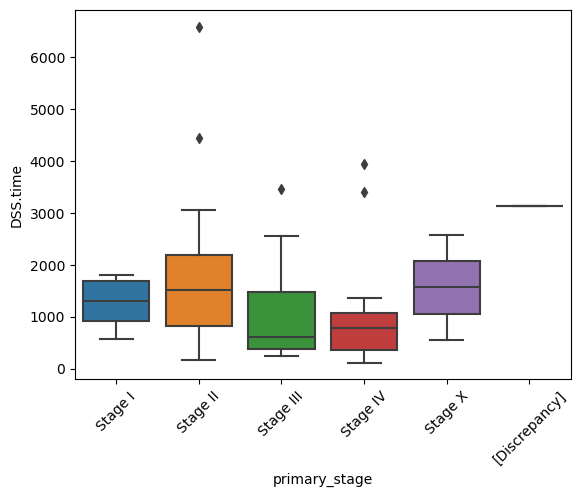

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot survival month by staging type, sorted by mean for each stage
plot_df = master.sort_values("primary_stage", ascending=True)
plot_df = plot_df.loc[plot_df["DSS"] == 1, :]
sns.boxplot(data=plot_df, x="primary_stage", y="DSS.time")

# rotate labels
plt.xticks(rotation=45)
plt.show()